In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import gc
import os
import time
import warnings
from itertools import combinations
from warnings import simplefilter
import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit
import polars as pl
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
# import logger


is_offline = True
LGB = True
NN = False
is_train = True
is_infer = True
max_lookback = np.nan
split_day = 435

In [2]:
!sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
!apt-get update --fix-missing

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clinfo is already the newest version (3.0.21.02.21-1).
Some packages could not be installed. This may mean that you have
requested an impossible situation or if you are using the unstable
distribution that some required packages have not yet been created
or been moved out of Incoming.
The following information may help to resolve the situation:

The following packages have unmet dependencies:
 libnvidia-compute-510 : Depends: libnvidia-compute-525 but it is not installable
 nvidia-cuda-dev : Breaks: libcuda1 (< 495)
                   Recommends: libnvcuvid1 but it is not installable
E: Unable to correct problems, you have held broken packages.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  

In [3]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [4]:
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return w

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [6]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df

In [14]:

train_path = '/content/drive/MyDrive/ML Project/train.csv'
df = pd.read_csv(train_path)
df = df.dropna(subset=["target"])
df.reset_index(drop=True, inplace=True)
df_shape = df.shape

In [15]:
len(set(df['date_id'].values))

481

In [16]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val

            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

# Feature Generation Function

In [17]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)

    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])

    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']

    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)


    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    gc.collect()

    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')

    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60
    df["minute"] = df["seconds_in_bucket"] // 60
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']

    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]

    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect()
    df = other_features(df)
    gc.collect()
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]

    return df[feature_name]

In [10]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

In [ ]:
weights

# Data Splitting

In [18]:
split_day=100
is_offline = True
if is_offline:

    df_train = df[df["date_id"] <= split_day]
    df_valid = df[(df["date_id"] > split_day) & (df["date_id"] <= split_day+100)]
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")

else:
    df_train = df
    print("Online mode")

Offline mode
train : (1078079, 17), valid : (1085095, 17)


In [19]:
if is_train:

    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    df_train = reduce_mem_usage(df_train)
    if is_offline:
        df_train_feats = generate_all_features(df_train)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        df_train_feats = generate_all_features(df_train)
        print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)

Build Train Feats Finished.
Build Valid Feats Finished.


In [65]:
df_train_feats

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,seconds,minute,time_to_market_close,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
0,0,0,3.180603e+06,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.500000,...,0,0,0,540,46823.980469,88988.632812,6.649432e+05,1.999666,0.002578,0.011596
1,1,0,1.666039e+05,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.040039,...,0,0,0,540,33043.000000,59380.230469,4.086799e+05,2.000077,0.004361,0.020203
2,2,0,3.028799e+05,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.000000,...,0,0,0,540,34609.000000,70184.851562,2.743088e+05,2.000762,0.005198,0.033413
3,3,0,1.191768e+07,-1,1.000171,1.838975e+07,NaN,NaN,0.999999,2324.899902,...,0,0,0,540,45480.039062,102700.039062,9.443996e+05,1.999779,0.002502,0.009547
4,4,0,4.475500e+05,-1,0.999532,1.786061e+07,NaN,NaN,0.999394,16485.539062,...,0,0,0,540,35195.308594,102103.679688,1.604066e+06,2.000183,0.003027,0.012817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078074,195,540,0.000000e+00,0,0.998127,1.679930e+07,0.998127,0.998127,0.998012,49962.429688,...,0,0,9,0,58905.601562,120582.445312,2.761659e+06,1.999861,0.002596,0.009862
1078075,196,540,6.668404e+05,-1,1.000626,9.102064e+06,0.999364,1.000085,1.000626,78670.640625,...,0,0,9,0,39578.121094,70981.312500,4.555811e+05,2.000059,0.003246,0.015339
1078076,197,540,8.707000e+03,1,0.999713,1.112104e+07,0.999799,0.999713,0.999454,85514.109375,...,0,0,9,0,34481.460938,73273.273438,5.222558e+05,2.000006,0.003433,0.014867
1078077,198,540,5.661338e+06,-1,0.997757,1.428711e+08,0.996959,0.997358,0.997757,209125.406250,...,0,0,9,0,291761.281250,321671.968750,1.827265e+06,1.999827,0.002631,0.012113


In [ ]:
df_train_feats.to_csv('train_feature_updated.csv')
df_valid_feats.to_csv('test_feature_updated.csv')

KeyboardInterrupt: ignored

# Model Training

In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

### LGBM

In [21]:
if LGB:
    import numpy as np
    import lightgbm as lgb

    lgb_params = {
        "objective": "mae",
        "n_estimators": 6000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
#         "learning_rate": 0.00871,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "device": "gpu",
        "verbosity": -1,
        "importance_type": "gain",
#         "reg_alpha": 0.1,
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }

    feature_columns = list(df_train_feats.columns)
    print(f"Features = {len(feature_columns)}")
    #print(f"Feature length = {len(feature_columns)}")

    num_folds = 2
    fold_size = 100 // num_folds
    gap = 2

    models = []
    models_cbt = []
    scores = []

    model_save_path = 'K_fold_models'
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    date_ids = df_train['date_id'].values

    for i in range(num_folds):
        start = i * fold_size
        end = start + fold_size
        if i < num_folds - 1:  # No need to purge after the last fold
            purged_start = end - 2
            purged_end = end + gap + 2
            train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
        else:
            train_indices = (date_ids >= start) & (date_ids < end)

        test_indices = (date_ids >= end) & (date_ids < end + fold_size)

        gc.collect()

        df_fold_train = df_train_feats[train_indices]
        df_fold_train_target = df_train['target'][train_indices]
        df_fold_valid = df_train_feats[test_indices]
        df_fold_valid_target = df_train['target'][test_indices]

        print(f"Fold {i+1} Model Training")

        # Train a LightGBM model for the current fold
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        lgb_model.fit(
            df_fold_train[feature_columns],
            df_fold_train_target,
            eval_set=[(df_fold_valid[feature_columns], df_fold_valid_target)],
            callbacks=[
                lgb.callback.early_stopping(stopping_rounds=100),
                lgb.callback.log_evaluation(period=100),
            ],
        )

#         cbt_model = cbt.CatBoostRegressor(objective='MAE', iterations=5000,bagging_temperature=0.5,
#                                 colsample_bylevel = 0.7,learning_rate = 0.065,
#                                 od_wait = 25,max_depth = 7,l2_leaf_reg = 1.5,
#                                 min_data_in_leaf = 1000,random_strength=0.65,
#                                 verbose=0,use_best_model=True,task_type='CPU')
#         cbt_model.fit(
#             df_fold_train[feature_columns],
#             df_fold_train_target,
#             eval_set=[(df_fold_valid[feature_columns], df_fold_valid_target)]
#         )

#         models_cbt.append(cbt_model)

        models.append(lgb_model)
        # Save the model to a file
        model_filename = os.path.join(model_save_path, f'kfold_lgbm_model_{i+1}.txt')
        lgb_model.booster_.save_model(model_filename)
        print(f"Model for fold {i+1} saved to {model_filename}")

        # Evaluate model performance on the validation set
        #------------LGB--------------#
        fold_predictions = lgb_model.predict(df_fold_valid[feature_columns])
        fold_score = mean_absolute_error(fold_predictions, df_fold_valid_target)
        scores.append(fold_score)
        print(f":LGB Fold {i+1} MAE: {fold_score}")
        #------------CBT--------------#
#         fold_predictions = cbt_model.predict(df_fold_valid[feature_columns])
#         fold_score_cbt = mean_absolute_error(fold_predictions, df_fold_valid_target)
#         scores.append(fold_score_cbt)
#         print(f"CBT Fold {i+1} MAE: {fold_score_cbt}")

        # Free up memory by deleting fold specific variables
        del df_fold_train, df_fold_train_target, df_fold_valid, df_fold_valid_target
        gc.collect()

    # Calculate the average best iteration from all regular folds
    average_best_iteration = int(np.mean([model.best_iteration_ for model in models]))

    # Update the lgb_params with the average best iteration
    final_model_params = lgb_params.copy()

    # final_model_params['n_estimators'] = average_best_iteration
    # print(f"Training final model with average best iteration: {average_best_iteration}")

    # Train the final model on the entire dataset
    num_model = 1

    for i in range(num_model):
        final_model = lgb.LGBMRegressor(**final_model_params)
        final_model.fit(
            df_train_feats[feature_columns],
            df_train['target'],
            callbacks=[
                lgb.callback.log_evaluation(period=100),
            ],
        )
        # Append the final model to the list of models
        models.append(final_model)

Features = 160
Fold 1 Model Training
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 6.25547
[200]	valid_0's l1: 6.19225
[300]	valid_0's l1: 6.14307
[400]	valid_0's l1: 6.09747
[500]	valid_0's l1: 6.05359
[600]	valid_0's l1: 6.01275
[700]	valid_0's l1: 5.9765
[800]	valid_0's l1: 5.9433
[900]	valid_0's l1: 5.91527
[1000]	valid_0's l1: 5.88828
[1100]	valid_0's l1: 5.86246
[1200]	valid_0's l1: 5.83869
[1300]	valid_0's l1: 5.81736
[1400]	valid_0's l1: 5.79427
[1500]	valid_0's l1: 5.77247
[1600]	valid_0's l1: 5.75086
[1700]	valid_0's l1: 5.73143
[1800]	valid_0's l1: 5.71232
[1900]	valid_0's l1: 5.69319
[2000]	valid_0's l1: 5.6735
[2100]	valid_0's l1: 5.65672
[2200]	valid_0's l1: 5.63884
[2300]	valid_0's l1: 5.62173
[2400]	valid_0's l1: 5.60445
[2500]	valid_0's l1: 5.58716
[2600]	valid_0's l1: 5.57299
[2700]	valid_0's l1: 5.55749
[2800]	valid_0's l1: 5.54184
[2900]	valid_0's l1: 5.52612
[3000]	valid_0's l1: 5.5114
[3100]	valid_0's l1: 5.49606
[3200]	valid_0'

In [23]:
final_model_path = '/content/drive/MyDrive/ML Project/final_models'

In [25]:
import joblib
# save model

# load model
count = 1
for model in models:
  joblib.dump(model, final_model_path+'/lgb'+str(count)+'.pkl')
  count+=1

In [62]:
final_model= models[0]

In [29]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import matplotlib.pyplot as plt

In [55]:
df_valid_prediction = df[df["date_id"]==]

In [68]:
dict(df_train_feats.isnull().sum())

{'stock_id': 0,
 'seconds_in_bucket': 0,
 'imbalance_size': 24,
 'imbalance_buy_sell_flag': 0,
 'reference_price': 24,
 'matched_size': 24,
 'far_price': 596216,
 'near_price': 588054,
 'bid_price': 24,
 'bid_size': 0,
 'ask_price': 24,
 'ask_size': 0,
 'wap': 24,
 'volume': 0,
 'mid_price': 24,
 'liquidity_imbalance': 0,
 'matched_imbalance': 24,
 'size_imbalance': 0,
 'reference_price_far_price_imb': 596216,
 'reference_price_near_price_imb': 588054,
 'reference_price_ask_price_imb': 24,
 'reference_price_bid_price_imb': 24,
 'reference_price_wap_imb': 24,
 'far_price_near_price_imb': 596216,
 'far_price_ask_price_imb': 596216,
 'far_price_bid_price_imb': 596216,
 'far_price_wap_imb': 596216,
 'near_price_ask_price_imb': 588054,
 'near_price_bid_price_imb': 588054,
 'near_price_wap_imb': 588054,
 'ask_price_bid_price_imb': 24,
 'ask_price_wap_imb': 24,
 'bid_price_wap_imb': 24,
 'ask_price_bid_price_wap_imb2': 949,
 'ask_price_bid_price_reference_price_imb2': 85738,
 'ask_price_wap_r

In [64]:
df_valid_feats

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,seconds,minute,time_to_market_close,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
0,0,0,7.428690e+06,1,0.999783,1.712297e+07,NaN,NaN,0.999994,284.429993,...,1,0,0,540,46823.980469,88988.632812,6.649432e+05,1.999666,0.002578,0.011596
1,1,0,1.096555e+05,-1,0.999432,1.494186e+06,NaN,NaN,0.999201,10369.200195,...,1,0,0,540,33043.000000,59380.230469,4.086799e+05,2.000077,0.004361,0.020203
2,2,0,3.502481e+05,-1,1.001319,2.393550e+06,NaN,NaN,0.997711,33196.589844,...,1,0,0,540,34609.000000,70184.851562,2.743088e+05,2.000762,0.005198,0.033413
3,3,0,1.948705e+07,1,0.999082,4.493185e+07,NaN,NaN,0.999227,144529.000000,...,1,0,0,540,45480.039062,102700.039062,9.443996e+05,1.999779,0.002502,0.009547
4,4,0,4.646706e+06,1,0.999799,7.771040e+06,NaN,NaN,0.999858,11344.440430,...,1,0,0,540,35195.308594,102103.679688,1.604066e+06,2.000183,0.003027,0.012817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085090,195,540,1.640897e+06,-1,1.001304,4.785948e+07,0.999900,1.000201,1.001204,4591.259766,...,0,0,9,0,58905.601562,120582.445312,2.761659e+06,1.999861,0.002596,0.009862
1085091,196,540,9.853852e+04,-1,1.001487,8.296411e+06,1.000155,1.000688,1.001487,7516.000000,...,0,0,9,0,39578.121094,70981.312500,4.555811e+05,2.000059,0.003246,0.015339
1085092,197,540,0.000000e+00,0,1.000842,2.075511e+07,1.000842,1.000842,1.000842,382.760010,...,0,0,9,0,34481.460938,73273.273438,5.222558e+05,2.000006,0.003433,0.014867
1085093,198,540,1.026508e+07,-1,1.000602,1.600525e+08,0.999414,0.999414,1.000364,20549.679688,...,0,0,9,0,291761.281250,321671.968750,1.827265e+06,1.999827,0.002631,0.012113


In [63]:

y_valid = df_valid_prediction['target']
y_pred = final_model.predict(df_valid_feats[:10835])

# accuracy check
mse = mean_squared_error(y_valid, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)



MSE: 51.77
RMSE: 7.19


In [37]:
train_split=dict(df_train['stock_id'].value_counts())

In [40]:
test_split=dict(df_valid['stock_id'].value_counts())

In [43]:
stock_id_test = []
for each_test in test_split:
  if test_split[each_test]>5000:
    stock_id_test.append(each_test)

stock_id_train = []
for each_train in train_split:
  if train_split[each_train]>5000:
    stock_id_train.append(each_train)

  # print(each_test)
  # break

In [49]:
from functools import reduce


intersection = reduce(lambda acc, x: acc + [x] if x in stock_id_train and x not in acc else acc, stock_id_test, [])

print(len(intersection))

192


In [47]:
# stock_id_test

In [46]:
# test_split

In [45]:
# train_split

In [59]:
mse = mean_squared_error(y_valid, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 51.88
RMSE: 7.20


In [58]:
import sklearn.metrics as metrics
print(metrics.r2_score(y_valid, y_pred))

0.05889379229696445


## Neural Network

In [ ]:
def create_mlp(num_continuous_features, num_categorical_features, embedding_dims, num_labels, hidden_units, dropout_rates, learning_rate,l2_strength=0.01):

    # Numerical variables input
    input_continuous = tf.keras.layers.Input(shape=(num_continuous_features,))

    # Categorical variables input
    input_categorical = [tf.keras.layers.Input(shape=(1,))
                         for _ in range(len(num_categorical_features))]

    # Embedding layer for categorical variables
    embeddings = [tf.keras.layers.Embedding(input_dim=num_categorical_features[i],
                                            output_dim=embedding_dims[i])(input_cat)
                  for i, input_cat in enumerate(input_categorical)]
    flat_embeddings = [tf.keras.layers.Flatten()(embed) for embed in embeddings]

    # concat numerical and categorical
    concat_input = tf.keras.layers.concatenate([input_continuous] + flat_embeddings)

    # MLP
    x = tf.keras.layers.BatchNormalization()(concat_input)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)

    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i],kernel_regularizer=l2(0.01),kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        #x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i+1])(x)

    #No activation
    out = tf.keras.layers.Dense(num_labels,kernel_regularizer=l2(0.01),kernel_initializer='he_normal')(x)

    model = tf.keras.models.Model(inputs=[input_continuous] + input_categorical, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
df_optiver = pd.read_csv(train_path)

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ML Project/test.csv')

In [ ]:


df_optiver.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [ ]:
df_optiver

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [ ]:
df_optiver['imbalance_buy_sell_flag'].value_counts()

-1    2084349
 1    2022037
 0    1131594
Name: imbalance_buy_sell_flag, dtype: int64

# The Dataset consists of 5 million rows. As part of initial analysis, I'm considering subset of stocks with the Stock Ids [38,39,40,101 ,46 ,103,79, 102, 135]

In [ ]:
# df_optiver['stock_id'].values
# [101 ,46 ,103,79, 102, 135]

In [ ]:
# df_optiver_id_subset = df_optiver[df_optiver['stock_id'].isin([38,39,40,101 ,46 ,103,79, 102, 135])]

In [ ]:
df_optiver_id_subset = df_optiver

In [ ]:
# df_optiver_id_subset.to_csv('Subset_dataset.csv')


In [ ]:
# df_optiver_id_subset.to_csv('Subset_dataset.csv')

In [ ]:
df_optiver_id_subset.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [ ]:
df_optiver_id_subset[['far_price', 'near_price']].describe()

,far_price,near_price
count,2.343638e+06,2.380800e+06
mean,1.001713e+00,9.996601e-01
std,7.214705e-01,1.216920e-02
min,7.700000e-05,7.869880e-01
25%,9.963320e-01,9.971000e-01
50%,9.998830e-01,9.998890e-01
75%,1.003318e+00,1.002590e+00
max,4.379531e+02,1.309732e+00


<ipython-input-20-82c2b758b63e>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_optiver_id_subset.corr()


<Axes: >

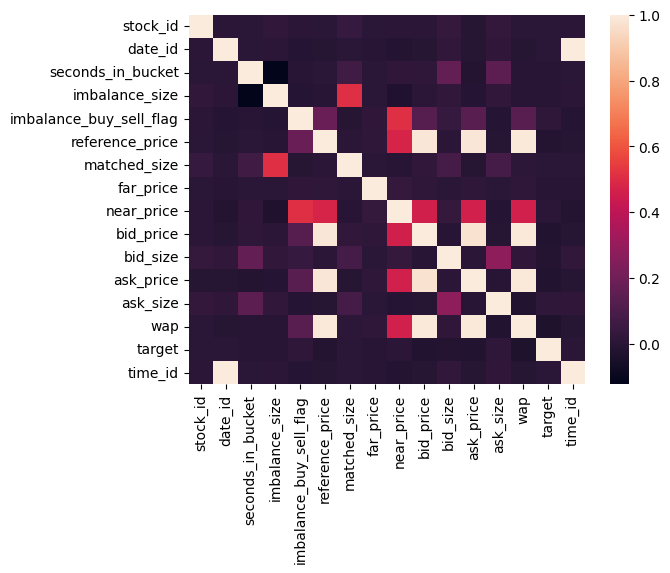

In [ ]:
# # load the Auto dataset
# auto_df = sns.load_dataset('mpg')

# calculate the correlation matrix on the numeric columns
corr = df_optiver_id_subset.corr()

# plot the heatmap
sns.heatmap(corr)

# Inorder to fill the null values in both the columns for far price and near price we need to analyze the correlation between multiple columns to analyze how filling null values would effect other columns

## Filling the null values with density distribution

### Training

<Axes: xlabel='near_price', ylabel='Density'>

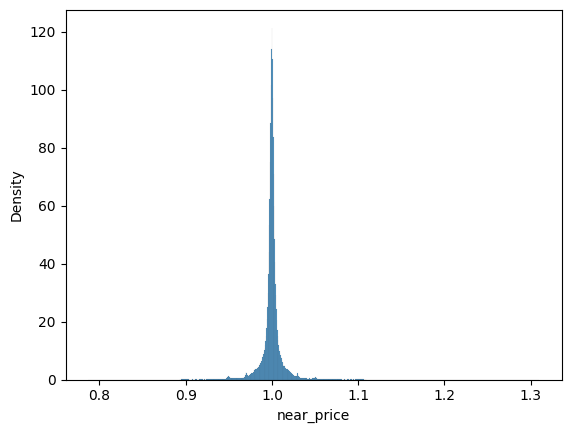

In [ ]:
sns.histplot(x=df_optiver_id_subset.near_price, stat='density', bins=1000)

<ipython-input-22-1466ee15bac5>:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  ydata, xdata = np.histogram(near_price_norm, bins=1000, normed=True)


Text(0.5, 0, 'Normalized near price')

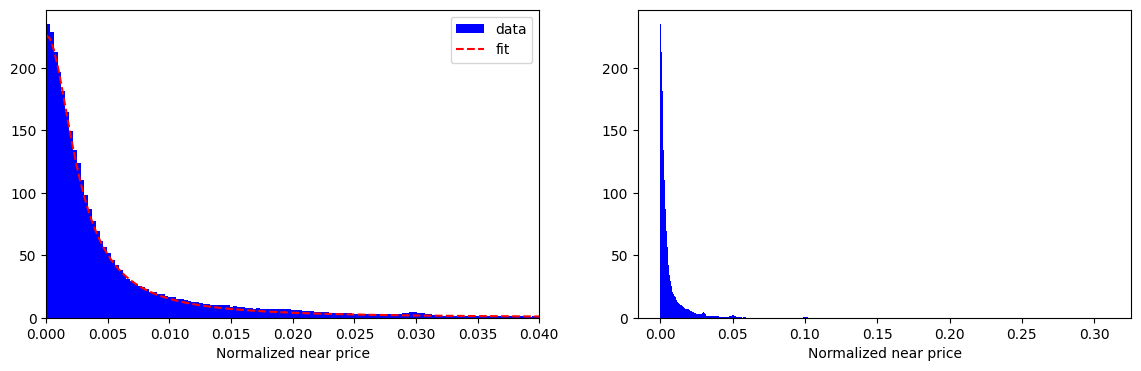

In [ ]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def near_price_fit(x, A, B):
    y = 1/(A + (B*x)**2)
    return y

near_price_norm = abs(df_optiver_id_subset.near_price - df_optiver_id_subset.near_price.mean()).dropna()
# near_price_norm_test = abs(df_test.near_price - df_test.near_price.mean()).dropna()
# df_test = pd.read_csv('/content/drive/MyDrive/ML Project/test.csv')

ydata, xdata = np.histogram(near_price_norm, bins=1000, normed=True)
parameters, covariance = curve_fit(near_price_fit, xdata[:-1], ydata)
fit_A_near = parameters[0]
fit_B_near = parameters[1]
fit = near_price_fit(xdata, fit_A_near, fit_B_near)

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(near_price_norm, bins=1000, label='data', density=True, color='blue')
plt.plot(xdata, fit, 'r--', label='fit')
plt.xlabel('Normalized near price')
plt.xlim((0,0.04))
plt.legend()
plt.subplot(122)
plt.hist(near_price_norm, bins=1000, label='data', density=True, color='blue')
plt.xlabel('Normalized near price')

In [ ]:
# train_dataset['near_price_norm'] = abs(train_dataset.near_price - train_dataset.near_price.mean())
df_optiver_id_subset['near_price_norm'] = df_optiver_id_subset.near_price
N_near_price = df_optiver_id_subset['near_price_norm'].isna().sum()
x = np.arange(-1.3, 1.3, step=0.00001)
prob = near_price_fit(x, fit_A_near, fit_B_near)
df_optiver_id_subset.loc[df_optiver_id_subset['near_price_norm'].isna(), 'near_price_norm'] = random.choices(x, weights=prob, k=N_near_price)
# train_dataset['near_price'] = train_dataset['near_price'].fillna(train_dataset['near_price'].mean())
df_optiver_id_subset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0.02787
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,-0.00194
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0.00194
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0.02186
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,-0.01335


### Testing

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


Text(0.5, 0, 'Normalized near price')

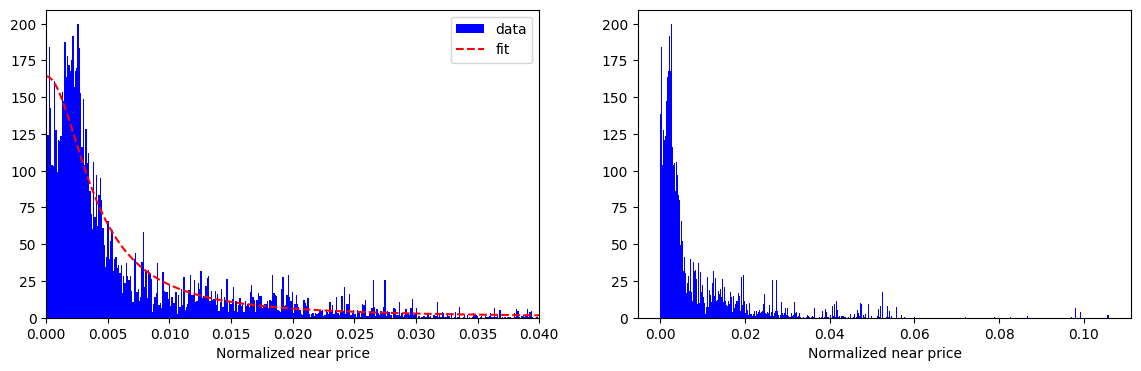

In [ ]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def near_price_fit(x, A, B):
    y = 1/(A + (B*x)**2)
    return y

near_price_norm = abs(df_test.near_price - df_test.near_price.mean()).dropna()
# near_price_norm_test = abs(df_test.near_price - df_test.near_price.mean()).dropna()
# df_test = pd.read_csv('/content/drive/MyDrive/ML Project/test.csv')

ydata, xdata = np.histogram(near_price_norm, bins=1000, normed=True)
parameters, covariance = curve_fit(near_price_fit, xdata[:-1], ydata)
fit_A_near = parameters[0]
fit_B_near = parameters[1]
fit = near_price_fit(xdata, fit_A_near, fit_B_near)

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(near_price_norm, bins=1000, label='data', density=True, color='blue')
plt.plot(xdata, fit, 'r--', label='fit')
plt.xlabel('Normalized near price')
plt.xlim((0,0.04))
plt.legend()
plt.subplot(122)
plt.hist(near_price_norm, bins=1000, label='data', density=True, color='blue')
plt.xlabel('Normalized near price')

In [ ]:
# train_dataset['near_price_norm'] = abs(train_dataset.near_price - train_dataset.near_price.mean())
df_test['near_price_norm'] = df_test.near_price
N_near_price_test = df_test['near_price_norm'].isna().sum()
x = np.arange(-1.3, 1.3, step=0.00001)
prob = near_price_fit(x, fit_A_near, fit_B_near)
df_test.loc[df_test['near_price_norm'].isna(), 'near_price_norm'] = random.choices(x, weights=prob, k=N_near_price_test)
# train_dataset['near_price'] = train_dataset['near_price'].fillna(train_dataset['near_price'].mean())
df_test.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,near_price_norm
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,26290,478_0_0,0.00486
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,26290,478_0_1,0.00162
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,26290,478_0_2,-0.00503
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,26290,478_0_3,0.00036
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,26290,478_0_4,-0.00536


In [ ]:
df_optiver_id_subset

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,0.027870
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1,-0.001940
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2,0.001940
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3,0.021860
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4,-0.013350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195,0.999734
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196,1.000386
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197,0.995789
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198,0.999210


# For Far Price

### train

<Axes: xlabel='far_price', ylabel='Density'>

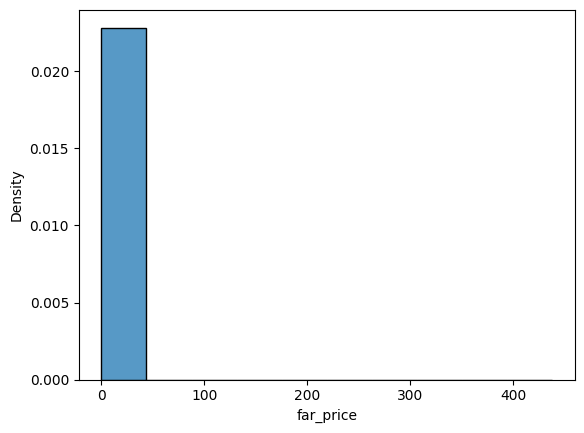

In [ ]:
sns.histplot(x=df_optiver_id_subset.far_price, stat='density', bins=10)

<ipython-input-26-d734883eedce>:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  ydata, xdata = np.histogram(far_price_norm, bins=1000, normed=True)


Text(0.5, 0, 'Normalized far price')

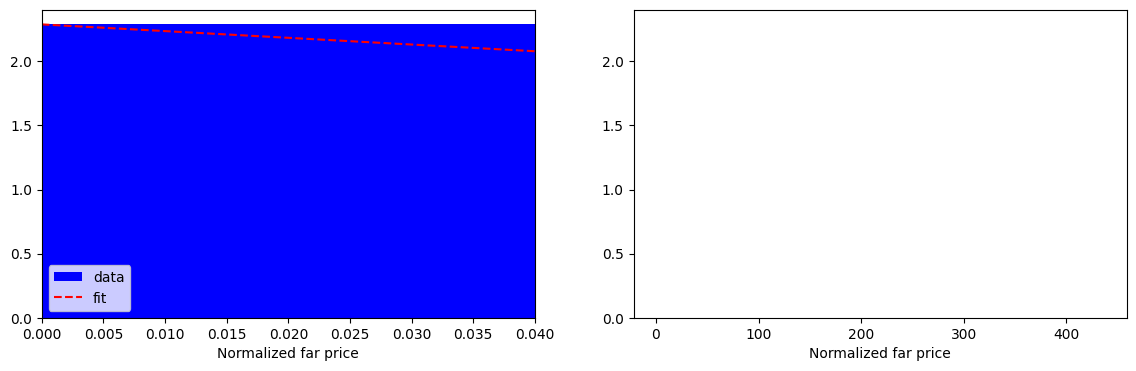

In [ ]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def far_price_fit(x, A, B):
    y = 1/(A + (B*x)**2)
    return y

far_price_norm = abs(df_optiver_id_subset.far_price - df_optiver_id_subset.far_price.mean()).dropna()

ydata, xdata = np.histogram(far_price_norm, bins=1000, normed=True)
parameters, covariance = curve_fit(far_price_fit, xdata[:-1], ydata)
fit_A_far = parameters[0]
fit_B_far = parameters[1]
fit = far_price_fit(xdata, fit_A_far, fit_B_far)

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(far_price_norm, bins=1000, label='data', density=True, color='blue')
plt.plot(xdata, fit, 'r--', label='fit')
plt.xlabel('Normalized far price')
plt.xlim((0,0.04))
plt.legend()
plt.subplot(122)
plt.hist(far_price_norm, bins=1000, label='data', density=True, color='blue')
plt.xlabel('Normalized far price')

In [ ]:
# train_dataset['far_price_norm'] = abs(train_dataset.far_price - train_dataset.far_price.mean())
df_optiver_id_subset['far_price_norm'] = df_optiver_id_subset.far_price
N_far_price = df_optiver_id_subset['far_price_norm'].isna().sum()
x = np.arange(-1.3, 1.3, step=0.00001)
prob = far_price_fit(x, fit_A_far, fit_B_far)
df_optiver_id_subset.loc[df_optiver_id_subset['far_price_norm'].isna(), 'far_price_norm'] = random.choices(x, weights=prob, k=N_far_price)
# train_dataset['far_price'] = train_dataset['far_price'].fillna(train_dataset['far_price'].mean())
df_optiver_id_subset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm,far_price_norm
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0.02787,0.00054
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,-0.00194,0.00192
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0.00194,-0.00135
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0.02186,-0.00012
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,-0.01335,0.00173


### test

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


Text(0.5, 0, 'Normalized far price')

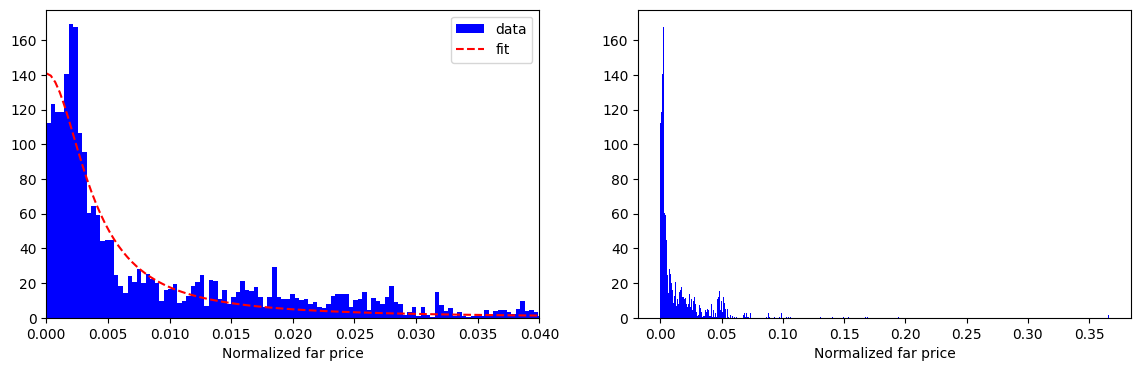

In [ ]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def far_price_fit(x, A, B):
    y = 1/(A + (B*x)**2)
    return y

far_price_norm = abs(df_test.far_price - df_test.far_price.mean()).dropna()

ydata, xdata = np.histogram(far_price_norm, bins=1000, normed=True)
parameters, covariance = curve_fit(far_price_fit, xdata[:-1], ydata)
fit_A_far = parameters[0]
fit_B_far = parameters[1]
fit = far_price_fit(xdata, fit_A_far, fit_B_far)

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(far_price_norm, bins=1000, label='data', density=True, color='blue')
plt.plot(xdata, fit, 'r--', label='fit')
plt.xlabel('Normalized far price')
plt.xlim((0,0.04))
plt.legend()
plt.subplot(122)
plt.hist(far_price_norm, bins=1000, label='data', density=True, color='blue')
plt.xlabel('Normalized far price')

In [ ]:
# train_dataset['far_price_norm'] = abs(train_dataset.far_price - train_dataset.far_price.mean())
df_test['far_price_norm'] = df_test.far_price
N_far_price = df_test['far_price_norm'].isna().sum()
x = np.arange(-1.3, 1.3, step=0.00001)
prob = far_price_fit(x, fit_A_far, fit_B_far)
df_test.loc[df_test['far_price_norm'].isna(), 'far_price_norm'] = random.choices(x, weights=prob, k=N_far_price)
# train_dataset['far_price'] = train_dataset['far_price'].fillna(train_dataset['far_price'].mean())
df_test.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,near_price_norm,far_price_norm
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,26290,478_0_0,0.00486,0.00141
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,26290,478_0_1,0.00162,0.00816
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,26290,478_0_2,-0.00503,0.01470
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,26290,478_0_3,0.00036,0.00256
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,26290,478_0_4,-0.00536,-0.06476


# remaining features Analysis

<Axes: xlabel='imbalance_buy_sell_flag', ylabel='Density'>

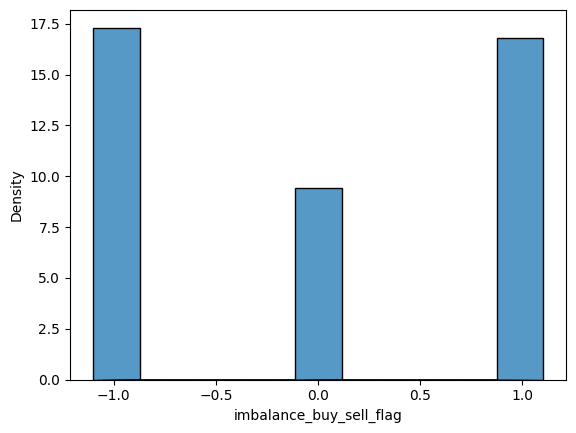

In [ ]:
sns.histplot(x=df_optiver_id_subset.imbalance_buy_sell_flag, shrink=10, stat='density')


<Axes: xlabel='date_id', ylabel='wap'>

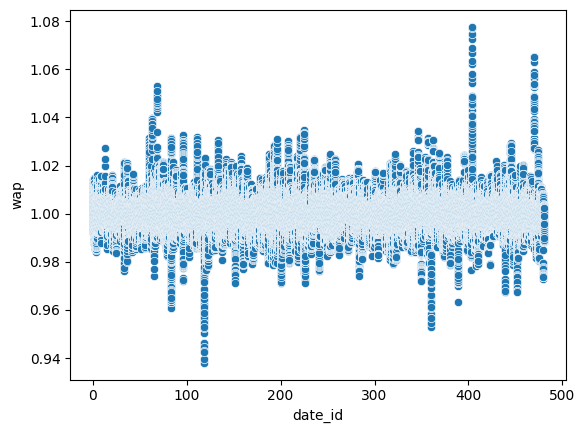

In [ ]:
sns.scatterplot(x=df_optiver_id_subset.date_id, y=df_optiver_id_subset.wap)

<Axes: xlabel='wap', ylabel='target'>

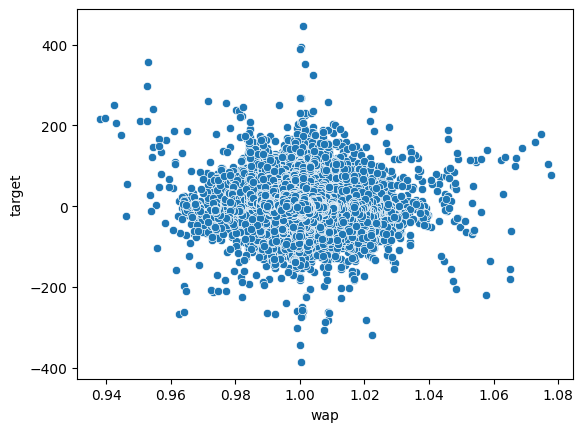

In [ ]:
sns.scatterplot(x=df_optiver_id_subset.wap, y=df_optiver_id_subset.target)

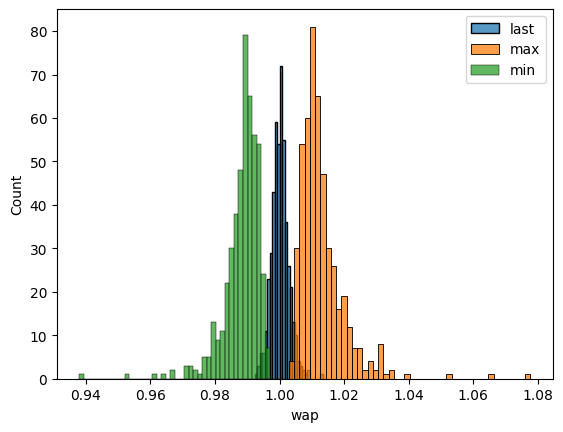

In [ ]:
# sns.histplot(x=train_dataset.groupby('date_id').first().near_price)
sns.histplot(x=df_optiver_id_subset.groupby('date_id').last().wap, label='last')
sns.histplot(x=df_optiver_id_subset.groupby('date_id').wap.max(), label='max')
sns.histplot(x=df_optiver_id_subset.groupby('date_id').wap.min(), label='min')
plt.legend()

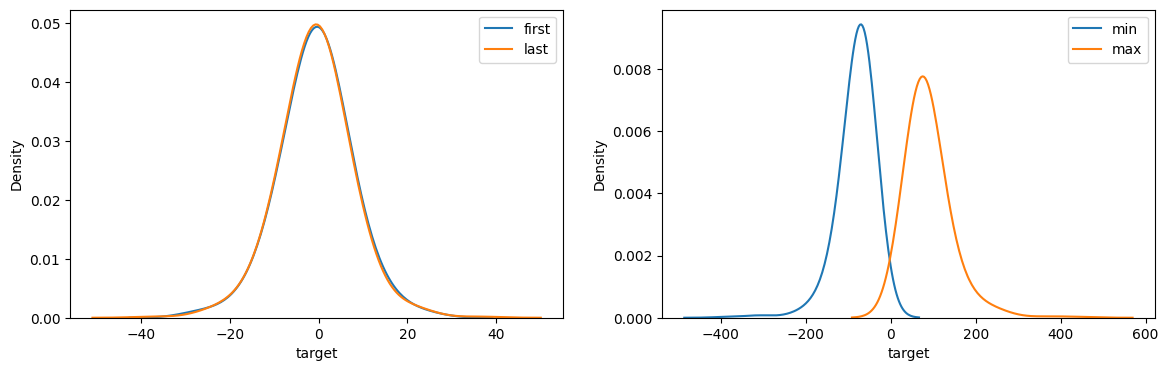

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.kdeplot(x=df_optiver_id_subset.groupby('date_id').target.first(), bw_adjust=2, label='first')
sns.kdeplot(x=df_optiver_id_subset.groupby('date_id').target.last(), bw_adjust=2, label='last')
plt.legend()
plt.subplot(122)
sns.kdeplot(x=df_optiver_id_subset.groupby('date_id').target.min(), bw_adjust=3, label='min')
sns.kdeplot(x=df_optiver_id_subset.groupby('date_id').target.max(), bw_adjust=3, label='max')
plt.legend()

<Axes: xlabel='target', ylabel='Density'>

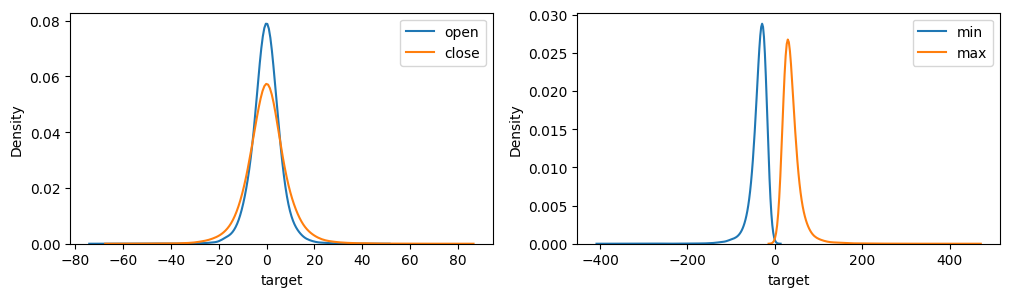

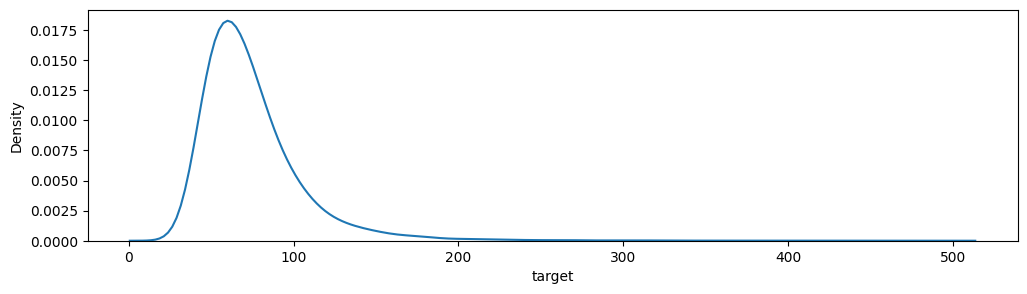

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(121)
sns.kdeplot(x=df_optiver_id_subset.groupby('time_id').target.first(), bw_adjust=2, label='open')
sns.kdeplot(x=df_optiver_id_subset.groupby('time_id').target.last(), bw_adjust=2, label='close')
plt.legend()
plt.subplot(122)
sns.kdeplot(x=df_optiver_id_subset.groupby('time_id').target.min(), bw_adjust=3, label='min')
sns.kdeplot(x=df_optiver_id_subset.groupby('time_id').target.max(), bw_adjust=3, label='max')
plt.legend()
plt.figure(figsize=(12,3))
sns.kdeplot(x=df_optiver_id_subset.groupby('time_id').target.max() - df_optiver_id_subset.groupby('time_id').target.min(), bw_adjust=2, label='max - min')

# Removing outliers

<Axes: xlabel='target'>

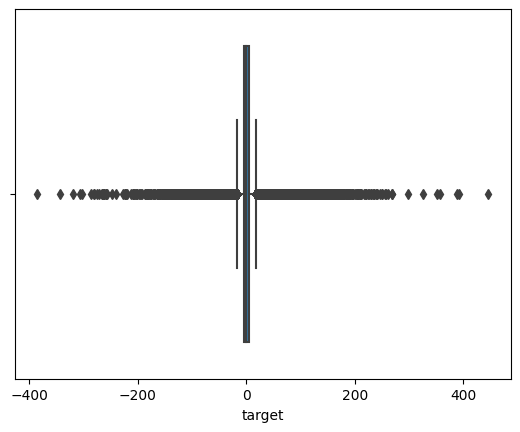

In [ ]:
sns.boxplot(x=df_optiver_id_subset.target)


In [ ]:
df_optiver_id_subset

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm,far_price_norm
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,0.027870,0.000540
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1,-0.001940,0.001920
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2,0.001940,-0.001350
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3,0.021860,-0.000120
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4,-0.013350,0.001730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195,0.999734,0.999734
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196,1.000386,1.000129
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197,0.995789,0.995789
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198,0.999210,0.999210


In [ ]:
df_optiver_id_subset.drop(columns=['far_price', 'near_price'])

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm,far_price_norm
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,0.027870,0.000540
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1,-0.001940,0.001920
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2,0.001940,-0.001350
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3,0.021860,-0.000120
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4,-0.013350,0.001730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195,0.999734,0.999734
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196,1.000386,1.000129
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197,0.995789,0.995789
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198,0.999210,0.999210


In [ ]:
q1 = np.nanpercentile(df_optiver_id_subset.target, 0.025, method='midpoint')
q3 = np.nanpercentile(df_optiver_id_subset.target, 0.975, method='midpoint')
iqr = q3 - q1
upper = q3 + 1.5*iqr
print(upper)
lower = q1 - 1.5*iqr
print(lower)
train_dataset_iqr = df_optiver_id_subset[(df_optiver_id_subset.target >= lower) & (df_optiver_id_subset.target <= upper)]

41.674974999999996
-138.404969


<Axes: xlabel='target'>

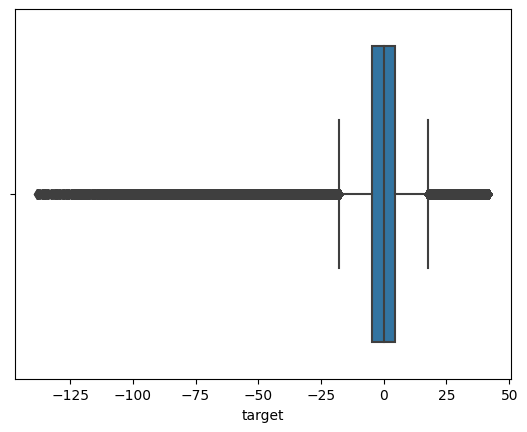

In [ ]:
sns.boxplot(x=train_dataset_iqr.target)

In [ ]:
print(df_optiver_id_subset.shape[0], train_dataset_iqr.shape[0])

5237980 5226512


# Feature Engineering
## For this first step, let's exclude the columns 'far_price' and 'near_price' with half missing values.
Remove the missing values in the remaining columns

In [ ]:
features = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price',
            'bid_size', 'ask_price', 'ask_size', 'wap']#, 'near_price_norm', 'far_price_norm']

features_size = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']
features_price = ['reference_price', 'bid_price', 'ask_price']#, 'near_price_norm', 'far_price_norm']
features_wap = ['wap']

In [ ]:
train_dataset_iqr[features_size].describe()

,imbalance_size,matched_size,bid_size,ask_size
count,5.226381e+06,5.226381e+06,5.226512e+06,5.226512e+06
mean,5.701071e+06,4.508772e+07,5.183049e+04,5.358009e+04
std,2.037371e+07,1.396188e+08,1.114742e+05,1.293908e+05
min,0.000000e+00,4.316610e+03,5.600000e-01,5.900000e-01
25%,8.438593e+04,5.293969e+06,7.383270e+03,7.824895e+03
50%,1.113899e+06,1.290320e+07,2.198190e+04,2.302200e+04
75%,4.190294e+06,3.272732e+07,5.584320e+04,5.788002e+04
max,2.982028e+09,7.713682e+09,3.028784e+07,5.440500e+07


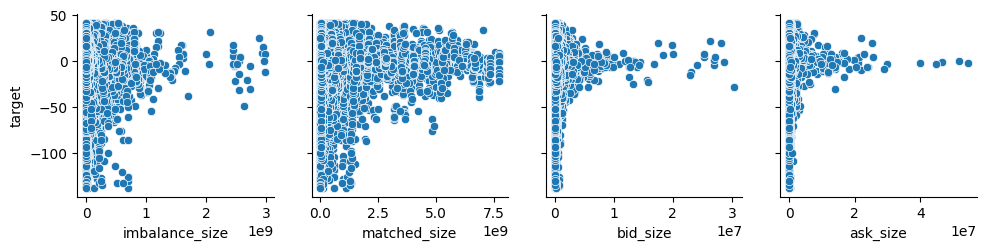

In [ ]:
g = sns.PairGrid(data=train_dataset_iqr, x_vars=features_size, y_vars='target')
g.map(sns.scatterplot)

In [ ]:
condition = (train_dataset_iqr.imbalance_size != 0) & (train_dataset_iqr.bid_size != 0) & (train_dataset_iqr.ask_size != 0) & (train_dataset_iqr.matched_size != 0)
train_dataset_filter = train_dataset_iqr[condition]
train_dataset_filter.shape

(4096954, 19)

In [ ]:
condition = (df_test.imbalance_size != 0) & (df_test.bid_size != 0) & (df_test.ask_size != 0) & (df_test.matched_size != 0)
df_test = df_test[condition]
df_test.shape

(28537, 18)

In [ ]:
train_dataset_iqr.shape

(5226512, 19)

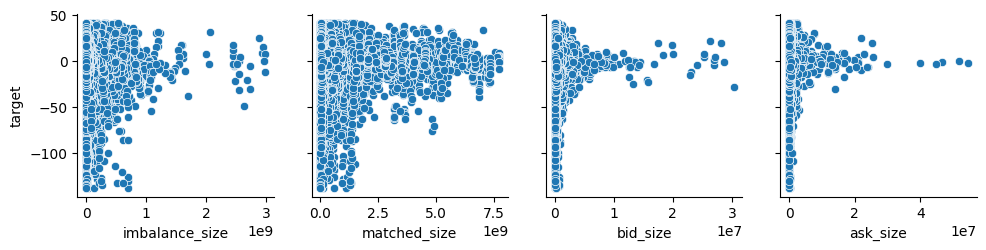

In [ ]:
g = sns.PairGrid(data=train_dataset_filter, x_vars=features_size, y_vars='target')
g.map(sns.scatterplot)

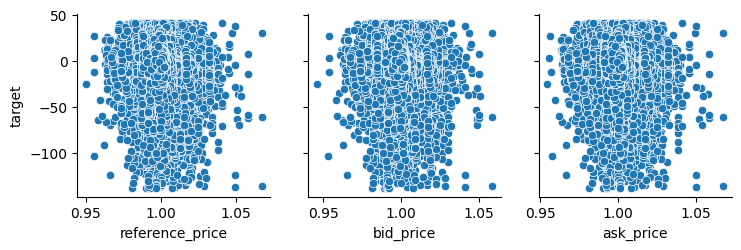

In [ ]:
g = sns.PairGrid(data=train_dataset_filter, x_vars=features_price, y_vars='target')
g.map(sns.scatterplot)

<Axes: xlabel='bid_price', ylabel='ask_price'>

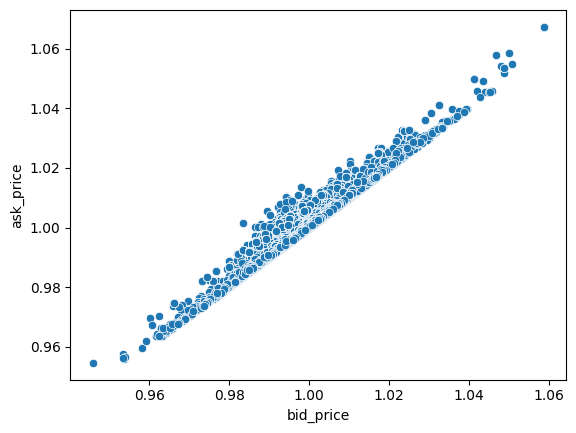

In [ ]:
sns.scatterplot(x=train_dataset_filter.bid_price, y=train_dataset_filter.ask_price)

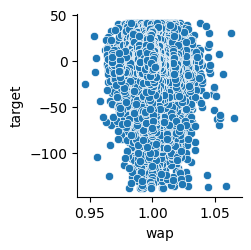

In [ ]:
g = sns.PairGrid(data=train_dataset_filter, x_vars=features_wap, y_vars='target')
g.map(sns.scatterplot)

In [ ]:
train_dataset_filter['volume'] = train_dataset_filter.eval('bid_size + ask_size')
train_dataset_filter["liquidity_imbalance"] = train_dataset_filter.eval("(bid_size-ask_size)/(bid_size+ask_size)")

weights = list(train_dataset_filter.stock_id.value_counts(normalize=True).sort_index())
weights = {int(k):v for k,v in enumerate(weights)}

train_dataset_filter['stock_weights'] = train_dataset_filter.stock_id.map(weights)
train_dataset_filter['weighted_wap'] = train_dataset_filter['stock_weights']*train_dataset_filter['wap']

train_dataset_filter.head()

<ipython-input-49-216b21ac6940>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_filter['volume'] = train_dataset_filter.eval('bid_size + ask_size')
<ipython-input-49-216b21ac6940>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_filter["liquidity_imbalance"] = train_dataset_filter.eval("(bid_size-ask_size)/(bid_size+ask_size)")
<ipython-input-49-216b21ac6940>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap,target,time_id,row_id,near_price_norm,far_price_norm,volume,liquidity_imbalance,stock_weights,weighted_wap
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,1.0,-3.029704,0,0_0_0,0.02787,0.00054,69144.53,0.754340,0.005281,0.005281
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,1.0,-5.519986,0,0_0_1,-0.00194,0.00192,23838.13,-0.728751,0.004164,0.004164
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,1.0,-8.389950,0,0_0_2,0.00194,-0.00135,56951.00,0.332935,0.004426,0.004426
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,1.0,-4.010200,0,0_0_3,0.02186,-0.00012,481357.30,-0.990340,0.005777,0.005777
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.0,-7.349849,0,0_0_4,-0.01335,0.00173,16919.64,0.948687,0.005323,0.005323


In [ ]:
df_test['volume'] = df_test.eval('bid_size + ask_size')
df_test["liquidity_imbalance"] = df_test.eval("(bid_size-ask_size)/(bid_size+ask_size)")

weights = list(df_test.stock_id.value_counts(normalize=True).sort_index())
weights = {int(k):v for k,v in enumerate(weights)}

df_test['stock_weights'] = df_test.stock_id.map(weights)
df_test['weighted_wap'] = df_test['stock_weights']*df_test['wap']

df_test.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_size,wap,time_id,row_id,near_price_norm,far_price_norm,volume,liquidity_imbalance,stock_weights,weighted_wap
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,...,9177.60,1.0,26290,478_0_0,0.00486,0.00141,32117.60,0.428500,0.005046,0.005046
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,...,19692.00,1.0,26290,478_0_1,0.00162,0.00816,21659.90,-0.818291,0.003539,0.003539
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,...,34955.12,1.0,26290,478_0_2,-0.00503,0.01470,39443.34,-0.772422,0.005116,0.005116
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,...,10314.00,1.0,26290,478_0_3,0.00036,0.00256,26396.04,0.218519,0.005572,0.005572
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,...,7245.60,1.0,26290,478_0_4,-0.00536,-0.06476,26257.95,0.448121,0.005397,0.005397


In [ ]:
train_dataset_filter.drop(columns=['far_price','near_price'],inplace=True)
df_test.drop(columns=['far_price','near_price'],inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_dataset_filter

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,...,wap,target,time_id,row_id,near_price_norm,far_price_norm,volume,liquidity_imbalance,stock_weights,weighted_wap
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,...,1.000000,-3.029704,0,0_0_0,0.027870,0.000540,69144.53,0.754340,0.005281,0.005281
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,...,1.000000,-5.519986,0,0_0_1,-0.001940,0.001920,23838.13,-0.728751,0.004164,0.004164
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,...,1.000000,-8.389950,0,0_0_2,0.001940,-0.001350,56951.00,0.332935,0.004426,0.004426
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,...,1.000000,-4.010200,0,0_0_3,0.021860,-0.000120,481357.30,-0.990340,0.005777,0.005777
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,...,1.000000,-7.349849,0,0_0_4,-0.013350,0.001730,16919.64,0.948687,0.005323,0.005323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237974,194,480,540,262271.52,-1,1.001504,3922295.41,1.001504,20829.20,1.001917,...,1.001557,4.839897,26454,480_540_194,1.000677,1.000677,160466.69,-0.740392,0.004460,0.004467
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,...,1.000328,2.310276,26454,480_540_195,0.999734,0.999734,352119.44,-0.816784,0.005348,0.005350
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,...,1.000819,-8.220077,26454,480_540_196,1.000386,1.000129,298501.47,0.374254,0.004889,0.004893
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,...,0.999008,-1.540184,26454,480_540_198,0.999210,0.999210,795524.72,-0.684154,0.005874,0.005868


In [ ]:
features = ['imbalance_size', 'matched_size', 'bid_price', 'ask_size',
            'bid_size', 'ask_price', 'reference_price', 'near_price_norm', 'far_price_norm',
            'wap',
            'volume', 'liquidity_imbalance']# 'stock_weights', 'weighted_wap'

In [ ]:
train_dataset_filter.drop(columns=['stock_weights','weighted_wap'],inplace=True)
df_test.drop(columns=['stock_weights','weighted_wap'],inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_dataset_filter.isna().sum()

stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size             131
imbalance_buy_sell_flag      0
reference_price            131
matched_size               131
bid_price                  131
bid_size                     0
ask_price                  131
ask_size                     0
wap                        131
target                       0
time_id                      0
row_id                       0
near_price_norm              0
far_price_norm               0
volume                       0
liquidity_imbalance          0
dtype: int64

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_dataset_drop_updated = reduce_mem_usage(train_dataset_drop)

Mem. usage decreased to 171.91 Mb (60.7% reduction)


In [ ]:
train_dataset_drop_updated

,imbalance_size,matched_size,bid_price,ask_size,bid_size,ask_price,reference_price,near_price_norm,far_price_norm,wap,volume,liquidity_imbalance,target
0,3.180603e+06,13380277.00,1.000000,8493.030273,60651.500000,1.000000,1.000000,0.027863,0.000540,1.000000,69144.531250,0.754395,-3.029297
1,1.666039e+05,1642214.25,1.000000,20605.089844,3233.040039,1.000977,1.000000,-0.001940,0.001920,1.000000,23838.130859,-0.728516,-5.519531
2,3.028799e+05,1819368.00,0.999512,18995.000000,37956.000000,1.000000,0.999512,0.001940,-0.001350,1.000000,56951.000000,0.333008,-8.390625
3,1.191768e+07,18389746.00,1.000000,479032.406250,2324.899902,1.000000,1.000000,0.021866,-0.000120,1.000000,481357.312500,-0.990234,-4.011719
4,4.475500e+05,17860614.00,0.999512,434.100006,16485.539062,1.000000,0.999512,-0.013351,0.001730,1.000000,16919.640625,0.948730,-7.351562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237974,2.622715e+05,3922295.50,1.001953,139637.484375,20829.199219,1.001953,1.001953,1.000977,1.000977,1.001953,160466.687500,-0.740234,4.839844
5237975,2.440723e+06,28280362.00,1.000000,319862.406250,32257.039062,1.000000,1.000000,0.999512,0.999512,1.000000,352119.437500,-0.816895,2.310547
5237976,3.495105e+05,9187699.00,1.000977,93393.070312,205108.406250,1.000977,1.000977,1.000000,1.000000,1.000977,298501.468750,0.374268,-8.218750
5237978,1.000899e+06,94773272.00,0.999023,669893.000000,125631.718750,0.999023,0.999023,0.999023,0.999023,0.999023,795524.750000,-0.684082,-1.540039


In [ ]:
train_dataset_drop_updated = train_dataset_drop_updated[features+['target']].dropna()
X = train_dataset_drop_updated.drop(columns='target')
y = train_dataset_drop_updated.target

In [ ]:
train_dataset_drop = train_dataset_filter[features+['target']].dropna()
X = train_dataset_drop.drop(columns='target')
y = train_dataset_drop.target

In [ ]:
df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,near_price_norm,far_price_norm,volume,liquidity_imbalance
0,0,478,0,3753451.43,-1,0.999875,11548975.43,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,0.004860,0.001410,32117.60,0.428500
1,1,478,0,985977.11,-1,1.000245,3850033.97,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,0.001620,0.008160,21659.90,-0.818291
2,2,478,0,599128.74,1,1.000584,4359198.25,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,-0.005030,0.014700,39443.34,-0.772422
3,3,478,0,2872317.54,-1,0.999802,27129551.64,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,0.000360,0.002560,26396.04,0.218519
4,4,478,0,740059.14,-1,0.999886,8880890.78,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,-0.005360,-0.064760,26257.95,0.448121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32994,194,480,540,262271.52,-1,1.001504,3922295.41,1.001504,20829.20,1.001917,139637.49,1.001557,26454,480_540_194,1.000677,1.000677,160466.69,-0.740392
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,0.999734,0.999734,352119.44,-0.816784
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,1.000386,1.000129,298501.47,0.374254
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,0.999210,0.999210,795524.72,-0.684154


In [ ]:
df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,near_price_norm,far_price_norm,volume,liquidity_imbalance
0,0,478,0,3753451.43,-1,0.999875,11548975.43,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,0.004860,0.001410,32117.60,0.428500
1,1,478,0,985977.11,-1,1.000245,3850033.97,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,0.001620,0.008160,21659.90,-0.818291
2,2,478,0,599128.74,1,1.000584,4359198.25,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,-0.005030,0.014700,39443.34,-0.772422
3,3,478,0,2872317.54,-1,0.999802,27129551.64,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,0.000360,0.002560,26396.04,0.218519
4,4,478,0,740059.14,-1,0.999886,8880890.78,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,-0.005360,-0.064760,26257.95,0.448121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32994,194,480,540,262271.52,-1,1.001504,3922295.41,1.001504,20829.20,1.001917,139637.49,1.001557,26454,480_540_194,1.000677,1.000677,160466.69,-0.740392
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,0.999734,0.999734,352119.44,-0.816784
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,1.000386,1.000129,298501.47,0.374254
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,0.999210,0.999210,795524.72,-0.684154


In [ ]:
df_test = df_test[features+['target']].dropna()
X_test = df_test.drop(columns='target')
y_test = df_test.target

KeyError: ignored

## Imports

In [ ]:
#basic tools
import os
import numpy as np
import pandas as pd
import warnings

#tuning hyperparameters
from bayes_opt import BayesianOptimization
# from skopt  import BayesSearchCV

#graph, plots
import matplotlib.pyplot as plt
import seaborn as sns

#building models
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import time
import sys

#metrics
from sklearn.metrics import roc_auc_score, roc_curve
import shap
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.4 MB/s eta 0:00:00


In [ ]:

def bayes_parameter_opt_lgb(train_dataset_drop_updated, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    # train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)

        cv_result = lgb.cv(params, train_dataset_drop_updated, nfold=n_folds, seed=random_seed, stratified=True, metrics=['auc'])
        return max(cv_result['auc-mean'])

    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)


    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341


ValueError: ignored

In [ ]:
train_dataset_drop.to_csv('data_after_preprocessing.csv')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train

,imbalance_size,matched_size,bid_price,ask_size,bid_size,ask_price,reference_price,near_price_norm,far_price_norm,wap,volume,liquidity_imbalance
1538162,3095911.43,5781810.52,1.002455,5291.63,1458.16,1.003555,1.003115,0.001400,-0.001400,1.002693,6749.79,-0.567939
3991754,147.83,9015956.72,0.997625,55669.80,73973.51,0.998437,0.997625,0.997625,0.997625,0.998089,129643.31,0.141185
3304585,6365548.90,14423996.95,0.998576,16301.00,36994.19,0.998821,0.998698,0.003350,0.002520,0.998746,53295.19,0.388275
2217167,616940.92,3941336.76,1.003249,74492.99,127459.80,1.003447,1.003447,1.006218,1.008196,1.003374,201952.79,0.262273
2213207,168619.76,23172987.44,0.997589,15466.20,14300.80,0.997812,0.997812,0.998035,0.998035,0.997696,29767.00,-0.039151
...,...,...,...,...,...,...,...,...,...,...,...,...
3117710,480194.22,1684708.25,1.002613,4044.00,95320.40,1.003854,1.002613,-0.005630,0.000760,1.003803,99364.40,0.918603
4539399,5189720.28,25450510.64,0.998540,123082.40,88085.16,0.999195,0.998993,0.002640,-0.004900,0.998813,211167.56,-0.165732
2953375,14600667.38,46037986.50,1.000118,9776.59,3471.30,1.000337,1.000227,-0.001770,-0.002710,1.000175,13247.89,-0.475947
3630084,1794198.80,73583911.23,0.998132,55473.48,57076.65,0.998373,0.998132,0.996446,0.995483,0.998254,112550.13,0.014244


In [ ]:
train_dataset_filter

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm,far_price_norm,volume,liquidity_imbalance
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,0.027870,0.000540,69144.53,0.754340
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1,-0.001940,0.001920,23838.13,-0.728751
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2,0.001940,-0.001350,56951.00,0.332935
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3,0.021860,-0.000120,481357.30,-0.990340
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4,-0.013350,0.001730,16919.64,0.948687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237974,194,480,540,262271.52,-1,1.001504,3922295.41,1.001504,20829.20,1.001917,139637.49,1.001557,4.839897,26454,480_540_194,1.000677,1.000677,160466.69,-0.740392
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195,0.999734,0.999734,352119.44,-0.816784
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196,1.000386,1.000129,298501.47,0.374254
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198,0.999210,0.999210,795524.72,-0.684154


In [ ]:
from sklearn import metrics

In [ ]:
model = LGBMRegressor(objective='mae',
                      random_seed = 123,
                      n_estimators = 500,
                      learning_rate = 0.01,
                      num_leaves = 400,
                      min_child_samples=3,)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.353309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 3072617, number of used features: 12
[LightGBM] [Info] Start training from score -0.090003


LGBMRegressor(learning_rate=0.01, min_child_samples=3, n_estimators=500,
              num_leaves=400, objective='mae', random_seed=123)

## LGBM

In [ ]:
model_pre = LGBMRegressor(objective='mae',
                      random_seed = 123,
                      n_estimators = 500,
                      learning_rate = 0.018,
                      num_leaves = 440,
                      reg_alpha = 0.01,
                      reg_lambda =  0.01,
                      max_depth= 9)
model_pre.fit(X, y)

In [ ]:
import joblib
# save model
joblib.dump(model_pre, 'lgb_trained.pkl')
# load model
# gbm_pickle = joblib.load('lgb.pkl')

['lgb_trained.pkl']

In [ ]:
model

LGBMRegressor(learning_rate=0.01, min_child_samples=3, n_estimators=500,
              num_leaves=400, objective='mae', random_seed=123)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import matplotlib.pyplot as plt

In [ ]:
y_pred = model.predict(X)

# accuracy check
mse = mean_squared_error(y, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

# MSE: 7.66
# RMSE: 2.77

MSE: 78.62
RMSE: 8.87


In [ ]:
print(metrics.r2_score(y_valid, y_pred))

0.030116497106790874


In [ ]:
y_pred

array([ 1.75256166,  2.78859517, -2.28984361, ...,  0.15386214,
       -0.17121682, -0.98451406])

In [ ]:
y_valid

5029082   -32.209755
1649652     6.879568
2974574    -3.119707
4848219     3.290176
1125232     9.809732
             ...    
1805811     5.890131
4448419    -0.169873
4516081     3.550053
4042259     9.299517
1637378    -8.829832
Name: target, Length: 15337, dtype: float64

In [ ]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
temp = dict(layout = go.Layout(font = dict(family="Franklin Gothic", size=12), width = 1500))

import torch
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, random_split
import time

In [ ]:

class LSTMwithAttention(nn.Module):
    def __init__(self, input_size=66, hidden_layer_size=50, output_size=1, num_layers=5):
        super().__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.batch_size = 1

        self.conv1d = nn.Conv1d(in_channels=66, out_channels=20, kernel_size=2)
        self.lstm = nn.LSTM(20, hidden_layer_size, num_layers, dropout=0.2)

        layers = [
                nn.Linear(hidden_layer_size, hidden_layer_size),
                nn.Linear(hidden_layer_size, hidden_layer_size),
                nn.Linear(hidden_layer_size, output_size)
                ]

        self.linear_layers = nn.Sequential(*layers)

        init_rnn(self.lstm, 'xavier')
        self.dropout = nn.Dropout(0.5)
        self.attn_weights = None

    def attention_net(self, lstm_output, final_state):
        lstm_output = lstm_output.permute(1, 0, 2)
        hidden = final_state.view(-1, self.hidden_layer_size, self.num_layers)
        self.attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)

        soft_attn_weights = torch.tanh(self.attn_weights)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights).squeeze(2)
        return context

    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0).permute(0, 2, 1)
        input_seq = self.conv1d(input_seq)
        input_seq = input_seq.permute(0, 2, 1)

        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq[0]), 1, 20))
        attn_output = self.attention_net(lstm_out, self.hidden_cell[0])

        out = self.linear_layers(attn_output.view(-1, self.hidden_layer_size))
        out = torch.tanh(out)

        return out[-1]

def init_rnn(x, type='uniform'):
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / (getattr(x, w).size(-1))**0.5
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / (getattr(x, w).size(-1))**0.5
                    init.normal_(getattr(x, w), 0.0, stdv)
                else:
                    raise ValueError

## Testing

In [ ]:
df_test.isnull().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  18229
near_price                 18000
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
time_id                        0
row_id                         0
dtype: int64

In [ ]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

ModuleNotFoundError: ignored

In [ ]:
!pip install optiver2023

ERROR: Could not find a version that satisfies the requirement optiver2023 (from versions: none)
ERROR: No matching distribution found for optiver2023
